In [110]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.regression.linear_model as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from pyearth import Earth
from sklearn.inspection import plot_partial_dependence
import matplotlib.pyplot as plt

## Part A

In [7]:
insurance = pd.read_csv("insurance.csv")

In [8]:
insurance.head()

age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

In [9]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [10]:
insurance.describe()

age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010

In [11]:
profile = ProfileReport(insurance, explorative=True)
profile.to_file("insurance_exploratory_analysis.html")

#### Refer to *insurance_exploratory_analysis.html* for exploratory analysis

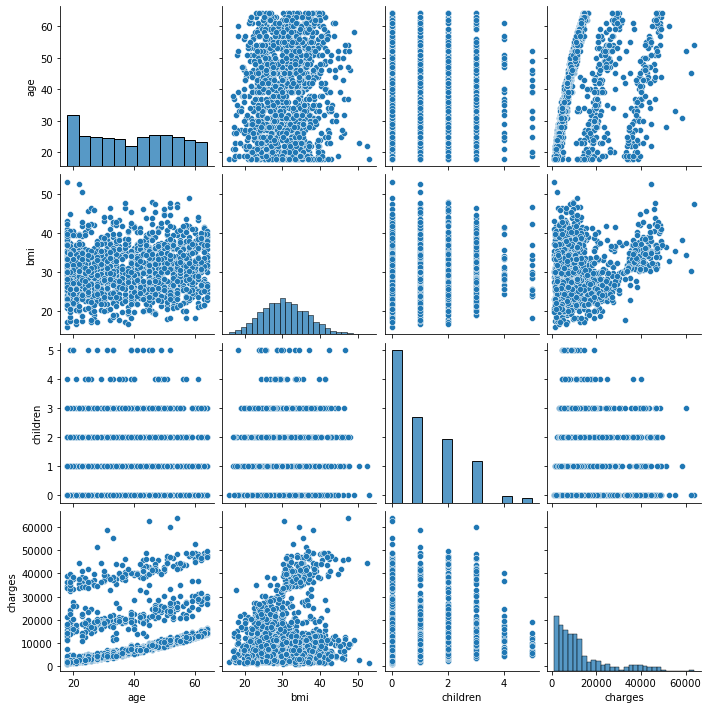

In [12]:
sns.pairplot(insurance)

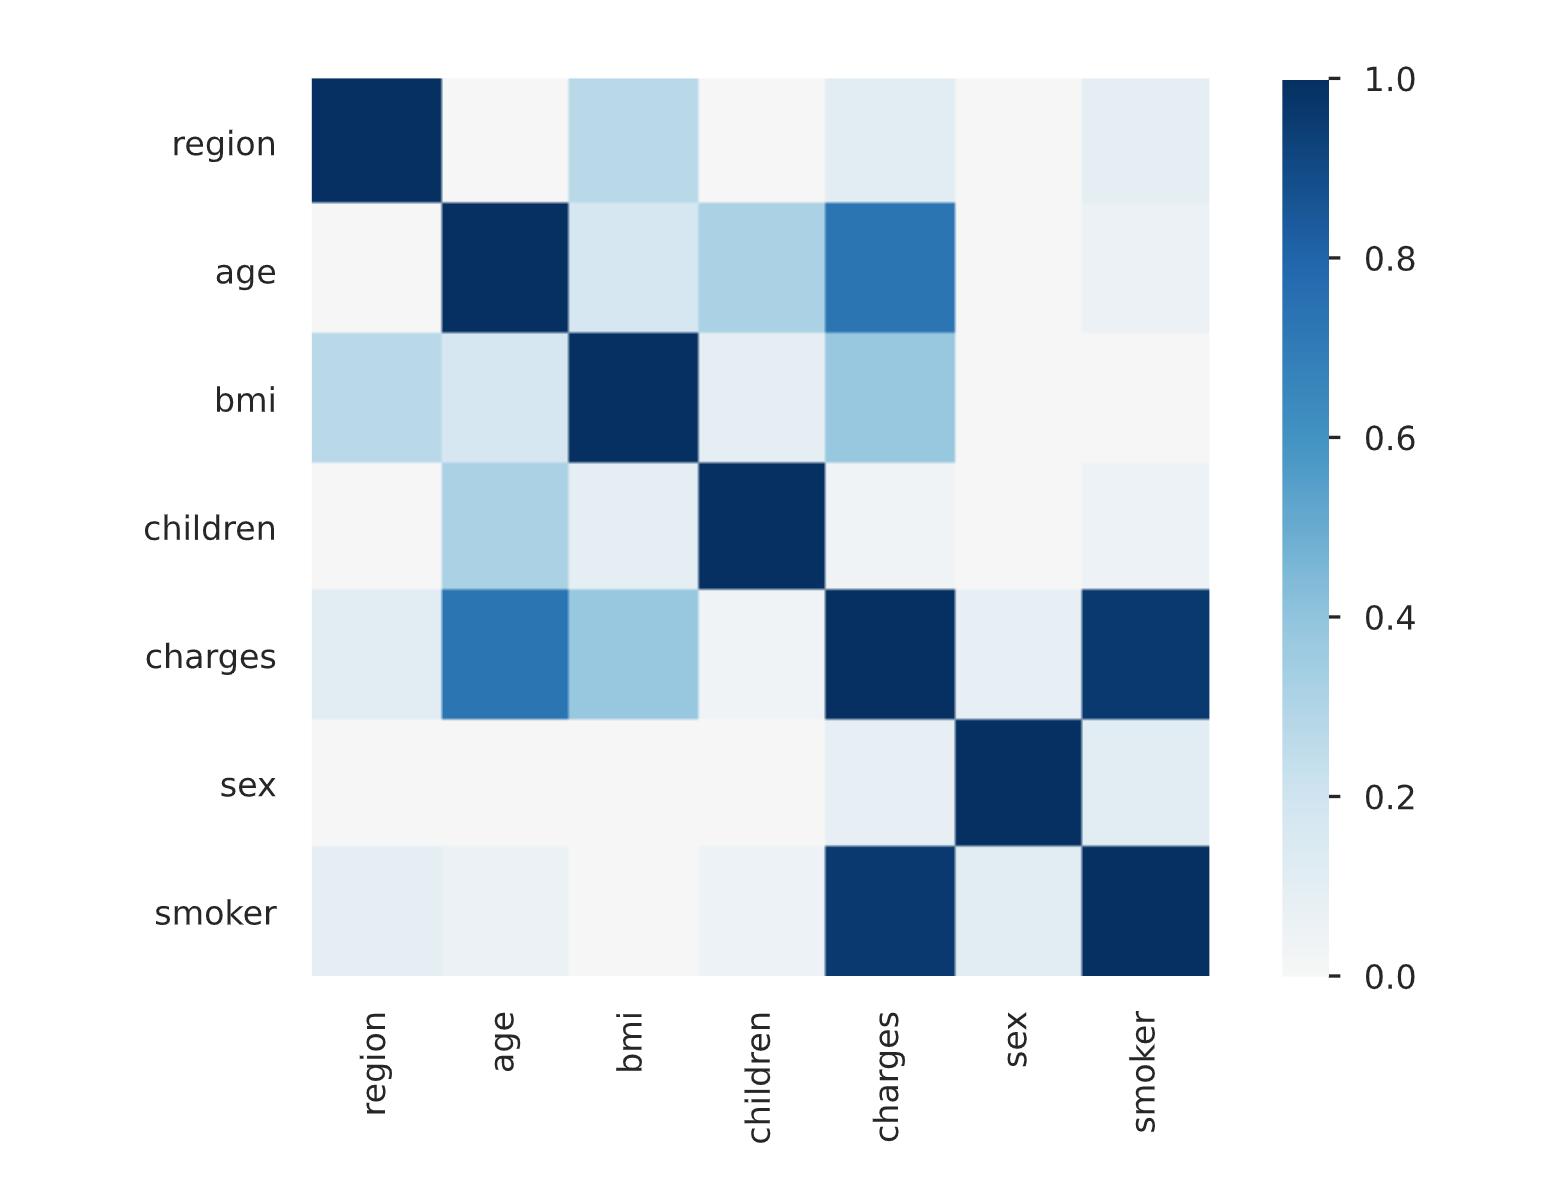

<AxesSubplot:xlabel='smoker', ylabel='charges'>

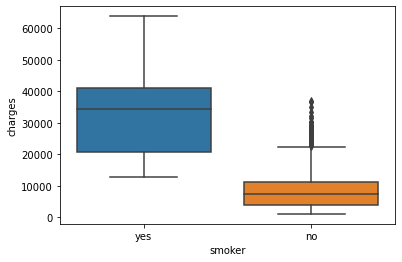

In [13]:
sns.boxplot(x="smoker", y="charges", data=insurance)

### smoker, age, and bmi seems like the most useful factors
but bmi is not very obvious

In [14]:
insurance.sex = insurance.sex.astype("category")
insurance.smoker = insurance.smoker.astype("category")
insurance.region = insurance.region.astype("category")

In [15]:
insurance.sex = insurance.sex.cat.codes
insurance.smoker = insurance.smoker.cat.codes

In [16]:
region_dummies = pd.get_dummies(insurance.region).drop("northeast", axis=1)

In [17]:
insurance = insurance.join(region_dummies).drop("region", axis=1)

In [18]:
insurance.head()

age  sex     bmi  children  smoker      charges  northwest  southeast  \
0   19    0  27.900         0       1  16884.92400          0          0   
1   18    1  33.770         1       0   1725.55230          0          1   
2   28    1  33.000         3       0   4449.46200          0          1   
3   33    1  22.705         0       0  21984.47061          1          0   
4   32    1  28.880         0       0   3866.85520          1          0   

   southwest  
0          1  
1          0  
2          0  
3          0  
4          0

sex: female = 0, male = 1

smoker: no = 0, yes = 1

region: baseline = northeast


In [19]:
X = insurance.drop("charges", axis=1)
Y = insurance.charges

# part 2

### 2. Train-test split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [21]:
(len(X_train), len(y_train), len(X_test), len(y_test))

(936, 936, 402, 402)

#### verify that the columns are correct

In [ ]:
(X_train.describe(), X_test.describe())

(              age         sex         bmi    children      smoker   northwest  \
 count  936.000000  936.000000  936.000000  936.000000  936.000000  936.000000   
 mean    39.471154    0.488248   30.752366    1.081197    0.202991    0.239316   
 std     14.012570    0.500129    6.235587    1.204195    0.402441    0.426894   
 min     18.000000    0.000000   15.960000    0.000000    0.000000    0.000000   
 25%     27.000000    0.000000   26.400000    0.000000    0.000000    0.000000   
 50%     40.000000    0.000000   30.305000    1.000000    0.000000    0.000000   
 75%     52.000000    1.000000   34.800000    2.000000    0.000000    0.000000   
 max     64.000000    1.000000   53.130000    5.000000    1.000000    1.000000   
 
         southeast   southwest  
 count  936.000000  936.000000  
 mean     0.276709    0.253205  
 std      0.447611    0.435080  
 min      0.000000    0.000000  
 25%      0.000000    0.000000  
 50%      0.000000    0.000000  
 75%      1.000000    1.00000

## 3 Develop Models

### 3a. Backward Elimination Linear Regression

In [59]:
x_train_ols = X_train.copy()

In [60]:
x_train_ols["intercept"] = [1 for i in range(936)]

In [61]:
# choose a Significance level usually 0.05, if p>0.05
#  for the highest values parameter, remove that value
ols = sm.OLS(endog = y_train, exog = x_train_ols).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     314.8
Date:                Wed, 31 Mar 2021   Prob (F-statistic):          3.47e-258
Time:                        03:14:57   Log-Likelihood:                -9495.3
No. Observations:                 936   AIC:                         1.901e+04
Df Residuals:                     927   BIC:                         1.905e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age          256.4354     14.628     17.531      0.000     227.728     285.143
sex          -47.5468    405.909     -0.117      0.907    -844.154     749.060
bmi          335.3691     34.437      9.738      0.000     267.785     402.954
children     472.7098    168.734      2.802      0.005     141.565     803.854
smoker      2.344e+04    507.660     46.165      0.000    2.24e+04    2.44e+04
northwest   -561.9011    590.574     -0.951      0.342   -1720.918     597.116
southeast   -994.7487    591.668     -1.681      0.093   -2155.912     166.414
southwest   -799.4489    585.816     -1.365      0.173   -1949.129     350.231
intercept  -1.184e+04   1205.932     -9.814      0.000   -1.42e+04   -9468.636
==============================================================================
Omnibus:                      232.849   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              571.734
Skew:                           1.309   Prob(JB):                    7.07e-125
Kurtosis:                       5.794   Cond. No.                         315.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
x_train_ols.drop("sex", axis=1, inplace=True)
ols = sm.OLS(endog = y_train, exog = x_train_ols).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     360.2
Date:                Wed, 31 Mar 2021   Prob (F-statistic):          1.78e-259
Time:                        03:14:57   Log-Likelihood:                -9495.3
No. Observations:                 936   AIC:                         1.901e+04
Df Residuals:                     928   BIC:                         1.905e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age          256.4634     14.618     17.544      0.000     227.775     285.151
bmi          335.2703     34.409      9.744      0.000     267.742     402.799
children     472.4458    168.629      2.802      0.005     141.507     803.384
smoker      2.343e+04    506.407     46.272      0.000    2.24e+04    2.44e+04
northwest   -560.5396    590.146     -0.950      0.342   -1718.715     597.636
southeast   -994.5980    591.352     -1.682      0.093   -2155.139     165.944
southwest   -798.1488    585.400     -1.363      0.173   -1947.010     350.712
intercept  -1.186e+04   1191.974     -9.947      0.000   -1.42e+04   -9516.973
==============================================================================
Omnibus:                      232.997   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              572.585
Skew:                           1.309   Prob(JB):                    4.62e-125
Kurtosis:                       5.797   Cond. No.                         311.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
x_train_ols.drop("northwest", axis=1, inplace=True)
ols = sm.OLS(endog = y_train, exog = x_train_ols).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     420.1
Date:                Wed, 31 Mar 2021   Prob (F-statistic):          1.30e-260
Time:                        03:14:58   Log-Likelihood:                -9495.8
No. Observations:                 936   AIC:                         1.901e+04
Df Residuals:                     929   BIC:                         1.904e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age          256.4005     14.617     17.541      0.000     227.714     285.087
bmi          335.7030     34.404      9.758      0.000     268.184     403.222
children     470.4089    168.607      2.790      0.005     139.515     801.303
smoker      2.344e+04    506.207     46.315      0.000    2.25e+04    2.44e+04
southeast   -712.0551    511.061     -1.393      0.164   -1715.023     290.912
southwest   -512.7051    502.349     -1.021      0.308   -1498.575     473.165
intercept  -1.215e+04   1150.519    -10.562      0.000   -1.44e+04   -9894.110
==============================================================================
Omnibus:                      233.187   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              571.844
Skew:                           1.311   Prob(JB):                    6.69e-125
Kurtosis:                       5.790   Cond. No.                         295.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
x_train_ols.drop("southwest", axis=1, inplace=True)
ols = sm.OLS(endog = y_train, exog = x_train_ols).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     503.9
Date:                Wed, 31 Mar 2021   Prob (F-statistic):          9.28e-262
Time:                        03:14:58   Log-Likelihood:                -9496.3
No. Observations:                 936   AIC:                         1.900e+04
Df Residuals:                     930   BIC:                         1.903e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age          257.1902     14.597     17.620      0.000     228.544     285.837
bmi          332.1063     34.224      9.704      0.000     264.941     399.271
children     462.5977    168.437      2.746      0.006     132.038     793.157
smoker      2.347e+04    505.811     46.392      0.000    2.25e+04    2.45e+04
southeast   -519.8820    475.121     -1.094      0.274   -1452.315     412.551
intercept  -1.225e+04   1146.422    -10.687      0.000   -1.45e+04      -1e+04
==============================================================================
Omnibus:                      234.162   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              575.583
Skew:                           1.316   Prob(JB):                    1.03e-125
Kurtosis:                       5.799   Cond. No.                         294.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [65]:
x_train_ols.drop("southeast", axis=1, inplace=True)
ols = sm.OLS(endog = y_train, exog = x_train_ols).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     629.4
Date:                Wed, 31 Mar 2021   Prob (F-statistic):          6.32e-263
Time:                        03:14:58   Log-Likelihood:                -9496.9
No. Observations:                 936   AIC:                         1.900e+04
Df Residuals:                     931   BIC:                         1.903e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age          257.8253     14.587     17.675      0.000     229.198     286.452
bmi          320.9618     32.677      9.822      0.000     256.833     385.090
children     469.3705    168.341      2.788      0.005     138.999     799.742
smoker      2.342e+04    503.771     46.480      0.000    2.24e+04    2.44e+04
intercept  -1.207e+04   1135.114    -10.637      0.000   -1.43e+04   -9846.991
==============================================================================
Omnibus:                      232.980   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              570.191
Skew:                           1.311   Prob(JB):                    1.53e-124
Kurtosis:                       5.783   Cond. No.                         290.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [66]:
x_test_ols = X_test.copy()

In [67]:
x_test_ols["intercept"] = [1 for i in range(402)]

In [72]:
x_test_ols = x_test_ols[["age", "bmi", "children", "smoker", "intercept"]]

In [73]:
x_train_ols.head()

age     bmi  children  smoker  intercept
1163   18  28.215         0       0          1
196    39  32.800         0       0          1
438    52  46.750         5       0          1
183    44  26.410         0       0          1
1298   33  27.455         2       0          1

In [74]:
x_test_ols.head()

age     bmi  children  smoker  intercept
578    52  30.200         1       0          1
610    47  29.370         1       0          1
569    48  40.565         2       1          1
1034   61  38.380         0       0          1
198    51  18.050         0       0          1

In [75]:
lr_y_predicted = ols.predict(x_test_ols)

In [76]:
rmse_lr = mean_squared_error(y_test, lr_y_predicted, squared=False); rmse_lr

5794.602828376949

### 3b. MARS

In [40]:
np.warnings.filterwarnings('ignore')

In [89]:
mars = Earth(max_degree=2, feature_importance_type="gcv")

In [90]:
mars.fit(X=X_train, y=y_train)

Earth(feature_importance_type='gcv', max_degree=2)

In [91]:
mars_y_predicted = mars.predict(X_test)

In [92]:
rmse_mars = mean_squared_error(y_test, mars_y_predicted, squared=False); rmse_mars

4407.908466426777

### 3c. Random Forest

In [98]:
rf = RandomForestRegressor(max_features='log2')

In [99]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_features='log2')

In [100]:
rf_y_predicted = rf.predict(X_test)

In [101]:
rmse_rf = mean_squared_error(y_test, rf_y_predicted, squared=False); rmse_rf

4423.349566392681

In [102]:
rmse = pd.DataFrame({"Testset RMSE": [rmse_lr, rmse_mars, rmse_rf]}, 
                    index=["Backward Elimination Linear Regression", "MARS", "Random Forest"])

In [103]:
rmse["Testset RMSE"] = rmse["Testset RMSE"].round(0)

#### RMSE table

In [104]:
rmse

Testset RMSE
Backward Elimination Linear Regression        5795.0
MARS                                          4408.0
Random Forest                                 4423.0

# Part C

In [105]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

### MARS

In [106]:
fi_mars = rf_feat_importance(mars, X)
plot_fi(fi_mars)

<AxesSubplot:ylabel='cols'>

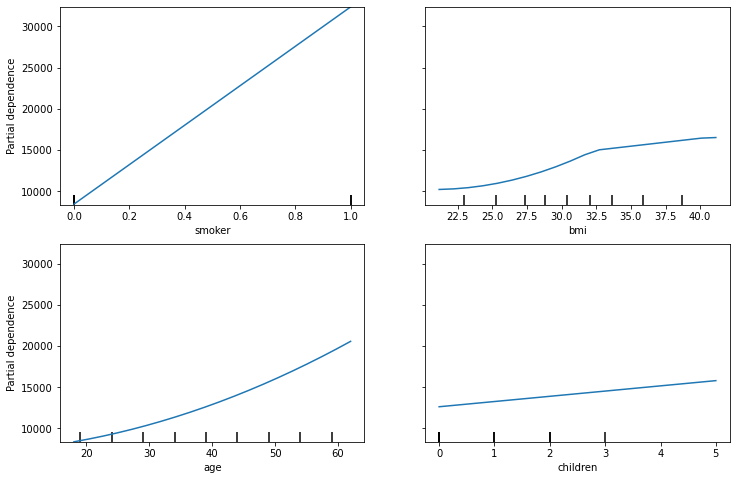

In [111]:
fig,ax = plt.subplots(2,2, figsize=(12, 8))
plot_partial_dependence(mars, X, ['smoker', 'bmi', 'age', 'children'],
                        grid_resolution=20, ax=ax)

### Random Forest

In [ ]:
fi = rf_feat_importance(rf, X)
plot_fi(fi)

<AxesSubplot:ylabel='cols'>

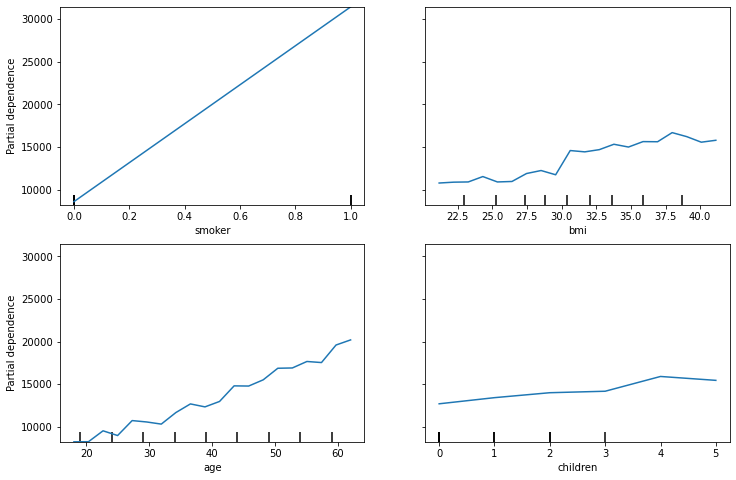

In [ ]:
fig,ax = plt.subplots(2,2, figsize=(12, 8))
plot_partial_dependence(rf, X, ['smoker', 'bmi', 'age', 'children'],
                        grid_resolution=20, ax=ax)

### both high accuracy models show the same trends
smoker, bmi and age have the most direct correlations to charges

## Part D

In [ ]:
r2_score(y_test, rf_y_predicted)

0.8619752758077511

### 5. Limitations

In [ ]:
insurance = pd.read_csv("insurance.csv")

In [ ]:
plt.hist(X.age)

(array([222., 140., 109., 128., 102., 137., 144., 114., 128., 114.]),
 array([18. , 22.6, 27.2, 31.8, 36.4, 41. , 45.6, 50.2, 54.8, 59.4, 64. ]),
 <BarContainer object of 10 artists>)

age is skewed to the left. Maybe it's not that younger patients are charged less. It's simply because our distribution is skewed.

In [ ]:
plt.hist(insurance.smoker, bins=2)

(array([ 274., 1064.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

smokers are heavily under-represented. Final distribution may be biased.

### 6. Enhancements
collect more data